# Biterm Topic Model (BTM)

##### Author information
- **Name:** Jaeseong Choe

- **email address:** 21900759@handong.ac.kr

- **GitHub:** https://github.com/sorrychoe

- **Linkedin:** https://www.linkedin.com/in/jaeseong-choe-048639250/

- **Personal Webpage:** https://jaeseongchoe.vercel.app/

## Part 1. Brief background of methodology

### Overview

- Biterm Topic Modeling(BTM) is a topic modeling technique designed to effectively handle short texts, such as social media posts, news headlines, or tweets. 

- BTM addresses the challenge of limited contextual information in short texts by focusing on word co-occurrence patterns (biterms) to extract meaningful topics.

### Situation Before BTM

- Traditional topic modeling algorithms like Latent Dirichlet Allocation (LDA) assume that documents are long enough to provide a variety of word occurrences, which is not the case for short texts.

- In short texts, LDA struggles because the limited word co-occurrence information makes it hard to identify coherent topics.

### Why BTM Was Introduced

- BTM was introduced from the paper *"A biterm topic model for short texts."* of Yan, X., Guo, J., Lan, Y., & Cheng, X. (2013).

- BTM was developed for overcome the limitations of LDA in short text topic modeling by directly modeling word co-occurrence patterns (biterms) across the entire collection of documents.

- It shifts the focus from individual documents to the global word-pair frequency, making it more suitable for extracting topics from short texts.

### Use Cases

- BTM is widely used in applications involving short text data, such as social media analysis, microblogging platforms (e.g., Twitter), news summarization, and customer feedback analysis.

## Part 2. Key concept of methodology

### Key Concept

- BTM models the co-occurrence of words in short texts using biterms, which are unordered pairs of words that appear within the same context.

### Generative Process

1. **Word Distribution for Topics**:
   - For each topic $z$, draw a topic-specific word distribution $\phi_z$ from a Dirichlet prior:
   $$
   \phi_z \sim \text{Dirichlet}(\beta)
   $$

2. **Topic Distribution**:
   - Draw a global topic distribution $\theta$ for the entire corpus from a Dirichlet prior:
   $$
   \theta \sim \text{Dirichlet}(\alpha)
   $$

3. **Biterm Generation**:
   - For each biterm $b = (w_i, w_j)$ in the biterm set $B$:
     - Draw a topic assignment $z$ from the topic distribution $\theta$:
     $$
     z \sim \text{Multinomial}(\theta)
     $$
     - Draw two words $w_i$ and $w_j$ from the topic-specific word distribution:
     $$
     w_i, w_j \sim \text{Multinomial}(\phi_z)
     $$



![BTM_Graphic](./img/BTM_Graphic.png)

### Mathematical Representation

- **Biterm Likelihood**:
   The likelihood of a biterm $b = (w_i, w_j)$ being generated from the model is:
   $$
   P(b) = \sum_z P(z) P(w_i | z) P(w_j | z)
   $$
   where $P(w_i | z) = \phi_{z,i}$, $P(w_j | z) = \phi_{z,j}$, and $P(z) = \theta_z$.

- **Corpus Likelihood**:
   The likelihood of the entire corpus, represented by the set of biterms $B$, is:
   $$
   P(B) = \prod_{(i,j)} \sum_z \theta_z \phi_{z,i} \phi_{z,j}
   $$
   This aggregates word co-occurrence patterns across the corpus.

### Inference:

BTM uses **collapsed Gibbs sampling** for inference, similar to LDA. The goal is to estimate the posterior distribution of the latent variables.

1. **Conditional Probability for Topic Assignment**:
   The conditional distribution for the topic assignment $z$ of a biterm $b = (w_i, w_j)$ is:
   
   $$
   P(z | z_{-b}, B, \alpha, \beta) \propto (n_z + \alpha) \cdot \frac{n_{w_i|z} + \beta}{\sum_w (n_{w|z} + \beta)} \cdot \frac{n_{w_j|z} + \beta}{\sum_w (n_{w|z} + \beta)}
   $$
   where:
   - $n_z$ is the number of biterms assigned to topic $z$,
   - $n_{w_i|z}$ is the number of times word $w_i$ is assigned to topic $z$,
   - $\alpha$ and $\beta$ are hyperparameters of the Dirichlet priors.

2. **Update Topic and Word Distributions**:
   Once the topic assignments are updated, the topic-word distributions $\phi_z$ and the global topic distribution $\theta$ are updated as:
   
   $$
   \phi_{w|z} = \frac{n_{w|z} + \beta}{\sum_w (n_{w|z} + \beta)}
   $$
   
   $$
   \theta_z = \frac{n_z + \alpha}{|B| + K \alpha}
   $$
   where $|B|$ is the total number of biterms, and $K$ is the number of topics.

### Strength

- BTM performs well on short texts because it utilizes biterms to enhance the understanding of topic distributions, making it possible to extract meaningful topics even when documents contain very few words.

## Part 3. Example

### Before Sample code

- There are many libraries of BTM, but no authenticated libraries exist yet. 

- The libraries that are positively evaluated by people are Python's bitermplus and R's BTM.

- In this Sample Code, I use the Python's `bitermplus`.

### Precautions

- If you re-execute the code, there may be a slight difference in the result.

- Of course, the difference in the number or content of the topic will not be significant due to the seed number and the learning rate, but the number of the topic changes.

In [6]:
# import librarys
import numpy as np # for data preprocessing
import pandas as pd # for load excel data
import bitermplus as btm # for topic modeling
import matplotlib.pyplot as plt # for visualization result
import seaborn as sns # for visualization result
from wordcloud import WordCloud # for visualization result as a wordcloud
import platform # for check the OS

# for ignore the warning message
import warnings
warnings.filterwarnings("ignore")

if platform.system() in ["Windows", "Linux"]:
    plt.rcParams["font.family"] = "Malgun Gothic"
    font_path = "malgun"

elif platform.system() == "Darwin":
    plt.rcParams["font.family"] = "AppleGothic"
    font_path = "AppleGothic"

else:
    print("Unsupported OS.")

plt.rcParams["axes.unicode_minus"] = False

In [7]:
# data load
# The data is related to Handong University, 
# which was reported in major Korean daily newspapers from January 1995 to September 2024.
df = pd.read_excel("data/NewsResult_19950101-20240930.xlsx", engine="openpyxl")

# Preprocessing text data
# In this case, I use the headline for BTM, not context.
# Becauese BTM is specialized in short texts.
headline = df['제목'].str.strip().tolist()

# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(headline)
tf = np.array(X.sum(axis=0)).ravel()

# Vectorizing documents
docs_vec = btm.get_vectorized_docs(headline, vocabulary)
docs_lens = list(map(len, docs_vec))

# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [18]:
def find_proper_t(X:np.ndarray, vocabulary:np.ndarray, start:int, end:int):
    """find proper k value for hyperparameter tunning"""
    for i in range(start, end+1):
        model = btm.BTM(X, vocabulary, seed=42, T=i, M=20, alpha=50/i, beta=0.01)
        coherence = btm.coherence(model.matrix_topics_words_, X, M=20)
        
        # initial value setup
        if i == start:
            proper_k = start
            tmp = np.mean(coherence)
        
        # print it out
        print('==== Coherence : k = {} ===='.format(i))
        print("\n")
        print('Average: {}'.format(np.mean(coherence)))
        print("\n")
        print('Per Topic:{}'.format(coherence))
        print("\n")
        print("\n")
        
        # update k
        if tmp < np.mean(coherence):
            proper_k = i
            tmp = np.mean(coherence)
    return proper_k

In [19]:
# find the proper T
topic_num = find_proper_t(X, vocabulary, 3, 10)

==== Coherence : k = 3 ====


Average: -30.865376084985098


Per Topic:[-30.86537608 -30.86537608 -30.86537608]




==== Coherence : k = 4 ====


Average: -30.865376084985098


Per Topic:[-30.86537608 -30.86537608 -30.86537608 -30.86537608]




==== Coherence : k = 5 ====


Average: -30.865376084985098


Per Topic:[-30.86537608 -30.86537608 -30.86537608 -30.86537608 -30.86537608]




==== Coherence : k = 6 ====


Average: -30.865376084985098


Per Topic:[-30.86537608 -30.86537608 -30.86537608 -30.86537608 -30.86537608
 -30.86537608]




==== Coherence : k = 7 ====


Average: -30.865376084985094


Per Topic:[-30.86537608 -30.86537608 -30.86537608 -30.86537608 -30.86537608
 -30.86537608 -30.86537608]




==== Coherence : k = 8 ====


Average: -30.865376084985098


Per Topic:[-30.86537608 -30.86537608 -30.86537608 -30.86537608 -30.86537608
 -30.86537608 -30.86537608 -30.86537608]




==== Coherence : k = 9 ====


Average: -30.8653760849851


Per Topic:[-30.86537608 -30.86537608 -30.865376

In [20]:
# train the model
model = btm.BTM(X, vocabulary, seed=42, T=topic_num, M=20, alpha=50/7, beta=0.01)
iterations = 2000
model.fit(biterms, iterations)

# extract the topics-words distribution
topic_word_dist = model.matrix_topics_words_

# print the topic's top word
def print_topics(topic_word_dist, vocab, n_top_words=7):
    for i, topic_dist in enumerate(topic_word_dist):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words-1:-1]
        print(f"Topic {i}: {' '.join(topic_words)}")

print_topics(topic_word_dist, vocabulary, n_top_words=10)

100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 275.24it/s]

Topic 0: 협상 트럼프 김정은 한국 압박 방위비 비핵화 북한 외교 미국
Topic 1: 한동대 개최 히딩크 연다 목회자 세미나 내달 유영익 목사 청소년
Topic 2: 한동대 교수 별세 위한 교육 대입 수능 동성애 대학 기독교
Topic 3: 한동대 총장 선정 김영길 대학 포항 합격 시험 교수 장순흥
Topic 4: 한동대 교수 포항 지진 이지선 만에 강연 정부 학생 위해
Topic 5: 포항 한동대 개최 인재 위한 대학 선정 개발 추진 육성
Topic 6: 대학 한동대 지원 대입 선발 수시 신입생 위해 모집 확대


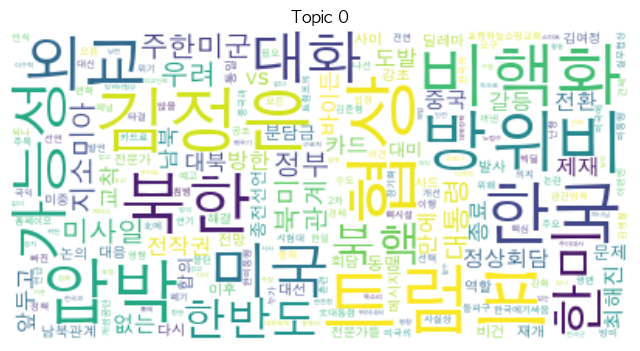

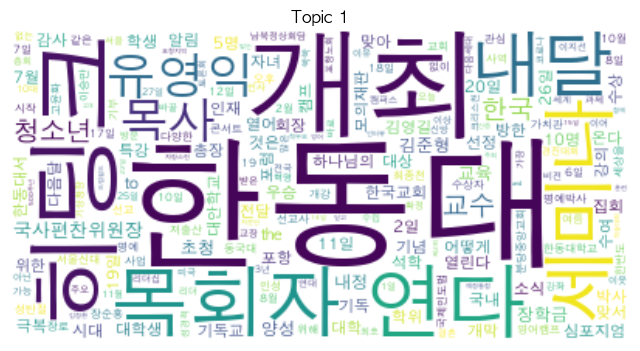

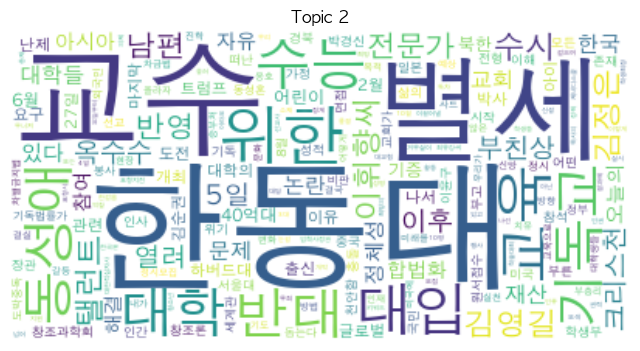

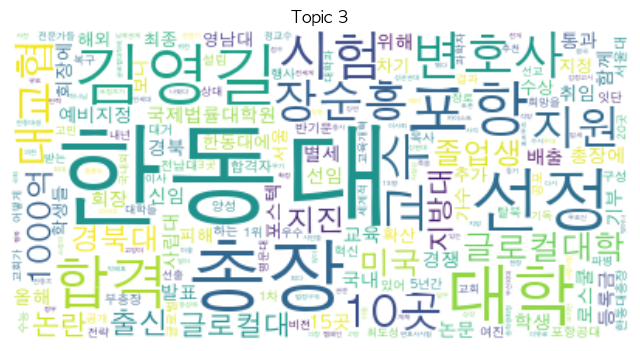

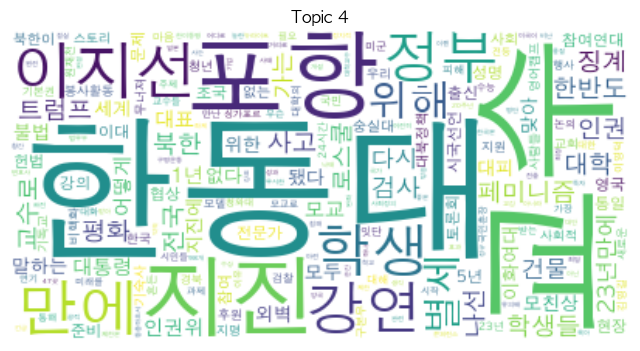

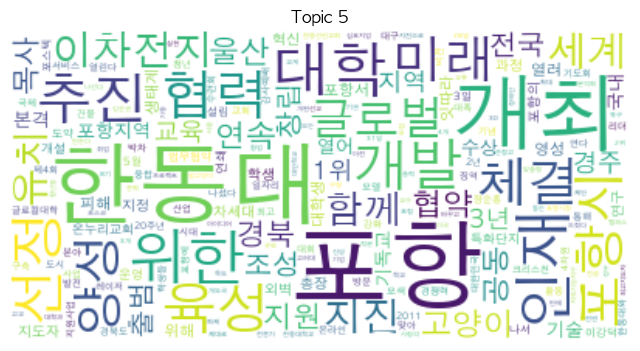

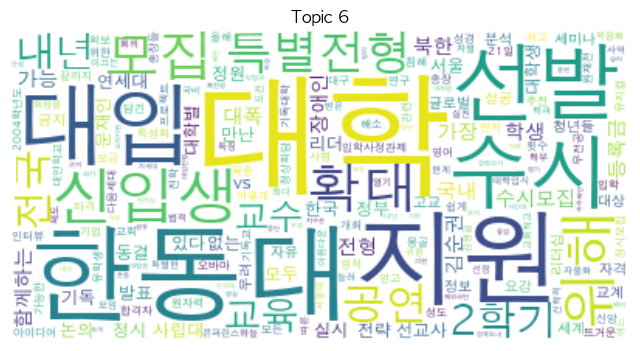

In [21]:
# make the wordcloud for show top word's frequency.
def draw_word_clouds(topic_word_dist, vocab):
    for i, topic_dist in enumerate(topic_word_dist):
        plt.figure(figsize=(8, 6))
        freq = {vocab[j]: topic_dist[j] for j in range(len(vocab))}
        wordcloud = WordCloud(background_color='white', font_path = "AppleGothic").generate_from_frequencies(freq)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {i}')
        plt.show()

draw_word_clouds(topic_word_dist, vocabulary)

### The result of Topic Modeling 

- Topic #0: Topic related to international politics

- Topic #1: Topic related to ministry-related seminars hosted by Handong University

- Topic #2: Topic related to Christian education at Handong University

- Topic #3: Topic related to educational performance of Handong University

- Topic #4: Topic related to a professor at Handong University

- Topic #5: Topic related to co-prosperity between Handong University and the region

- Topic #6: Topic related to Handong University entrance examination

100%|███████████████████████████████████| 8051/8051 [00:00<00:00, 255231.03it/s]


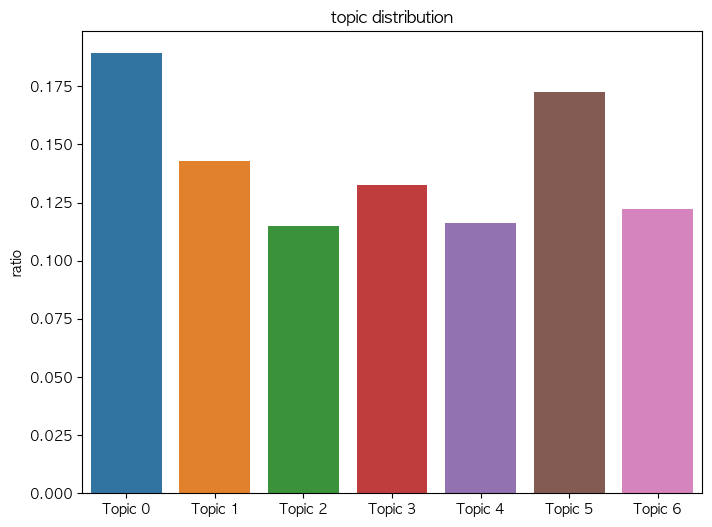

In [22]:
# make the histogram for show topic distribution
doc_topics = model.transform(docs_vec)
topic_proportions = doc_topics.mean(axis=0)

plt.figure(figsize=(8, 6))
sns.barplot(x=[f'Topic {i}' for i in range(len(topic_proportions))], y=topic_proportions)
plt.title('topic distribution')
plt.ylabel('ratio')
plt.show()

### Intrepretation of Topic Distribution

- The topic is generally even

- There are relatively more articles on topic 0 and topic 5